### Assignment nb-10.7 

I artificially generated occurrences of oil spill incidents in the time series by concatenating two Poisson distributions representing before and after the switching point. This switch point was set to be 1980, which was the year that the Oil Pollution Prevention regulation was implemented. By building a model and simulating the data, I estimated the change point in the series pretty close to the actual year.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import pymc3 as pm
import toyplot

In [2]:
# fix a random seed
np.random.seed(1234)

# generate data for 167 years with higher rates before 1980 when the Oil Pollution Prevention regulation was implemented.
data = pd.DataFrame({
    "year": np.arange(1850, 2017), #Values generated between 1850~2017
    "oilspills": np.concatenate([ 
        np.random.poisson(10.0, 130), #(Lamda=# of success, size=year) average 8 oilspills per year in the first 130 years
        np.random.poisson(3.0, 37), # average 3 oilspills per year in the last 37 years
    ])
})

# introduce some random NaN values (pymc3 will handle these)
missing = np.random.randint(0, data.shape[1], 5) # sample 5 values randomly in the dataset and assign nan to make 5 missing values in the dataset 
data.loc[missing, "oilspills"] = np.nan



In [3]:
data.head()

,oilspills,year
0,NaN,1850
1,NaN,1851
2,13.0,1852
3,8.0,1853
4,9.0,1854


In [4]:
# plot the generated data
toyplot.scatterplot(
    data.year,
    data.oilspills, 
    width=1500, 
    height=400,
    color=["orange"],
    size=15, 
    opacity=0.8,
    label="World-wide Oil spill Incidents",
    xlabel="Year", 
    ylabel="N Oil Spills",
);



1850 1900 1950 2000 Year 0 5 10 15 20 N Oil Spills World-wide Oil spill Incidents

### Build the model

Occurrences of oil spills in the time series I generated seems to follow a Poisson process with a large rate parameter in the majority of the time series, and one with a smaller rate in the last short part of the time series. I am interested in locating the change point in the series, which may be related to the implementation of the Oil Pollution Prevention regulation in 1980.

In [5]:
with pm.Model() as oilspill_model:

    # sample switchpoint from within the bounds of our data timescale
    switchpoint = pm.DiscreteUniform(
        'switchpoint',
        lower=data.year.min(), 
        upper=data.year.max(), 
        )

    # Priors for pre- and post-switch rates for number of disasters
    early_rate = pm.Exponential('early_rate', 1.)
    late_rate = pm.Exponential('late_rate', 1.)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= data.year, early_rate, late_rate) 
    #switch, a Theano function that works like an if statement. 
    #It uses the first argument to switch between the next two arguments.
   
    oilspills = pm.Poisson('oilspills', rate, observed=data.oilspills)

In [6]:
with oilspill_model:
    trace = pm.sample(100000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [oilspills_missing]
>>Metropolis: [switchpoint]
>NUTS: [late_rate_log__, early_rate_log__]
100%|█████████▉| 100486/100500 [02:11<00:00, 761.57it/s]/Users/teachinghouse/miniconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
100%|██████████| 100500/100500 [02:11<00:00, 761.43it/s]
/Users/teachinghouse/miniconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
Tuning was enabled throughout the whole trace.
Tuning was enabled throughout the whole trace.
The number of effective samples is smaller than 10% for some parameters.


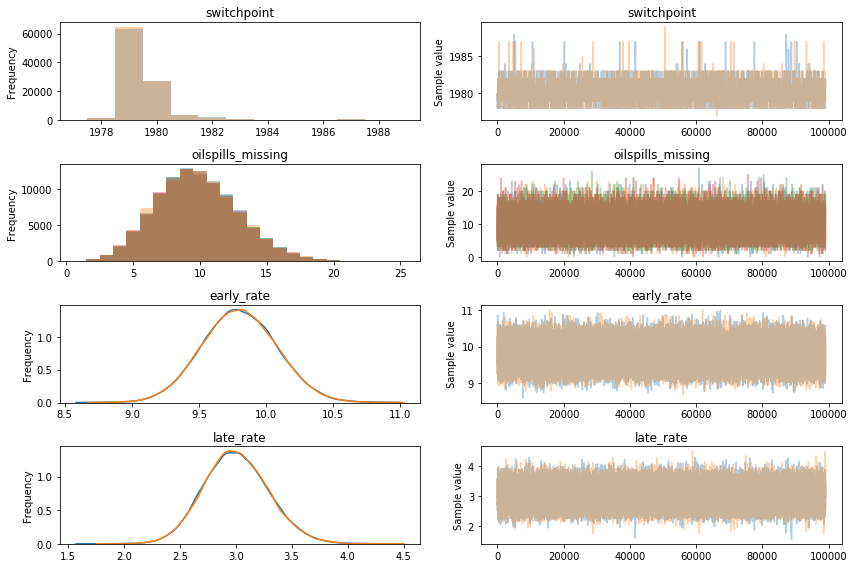

In [7]:
pm.traceplot(trace[1000:]);

In [8]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
switchpoint,1979.456295,0.921027,0.013112,1979.000000,1981.000000,5609.0,1.000013
oilspills_missing__0,9.824140,3.124659,0.018449,3.000000,15.000000,25560.0,1.000052
oilspills_missing__1,9.785290,3.144280,0.020914,3.000000,15.000000,25147.0,0.999998
early_rate,9.795753,0.277650,0.000833,9.247587,10.332186,130435.0,0.999995
late_rate,3.004612,0.289098,0.001102,2.452133,3.583705,89180.0,0.999995


The posterior estimate of switch point prediction was 1977, which was relatively close to the true year 1980. The estimated switch point was within the 95% highest posterior density. 

The simulated rates of oil-spill occurrence per year before and after the switch point are 10.0 and 3.0 respectively, which are about the same as the actual values.

I think I ran the MCMC sampler long enough because the poster estimates of the simulation with 10,000 values were almost the same as those with 100,000 values. I didn’t have any significant problems, but I tried to understand what this model was doing by testing out, and googling things. 